In [1]:
#import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import os
import sys
import matplotlib.pyplot as plt

In [2]:
deeplabv3plus_dir="./src"
sys.path.append(deeplabv3plus_dir)

In [3]:
gpu_options = tf.compat.v1.GPUOptions(visible_device_list="3", allow_growth=True)
config = tf.compat.v1.ConfigProto(gpu_options = gpu_options)
tf.compat.v1.enable_eager_execution(config=config)

In [4]:
#from model import deeplab_v3plus
from image_utils import make_x_from_image_paths,make_y_from_image_paths,convert_y_to_image_array, make_palette
from data_gen import DataGenerator

In [5]:
import importlib
importlib.reload(sys.modules['data_gen'])

<module 'data_gen' from './src/data_gen.py'>

In [24]:
model = keras.models.load_model("./xception_transfer_os16/000024.h5")

In [25]:
#model.summary()

In [26]:
n_categories = 21
image_size = (512,512)

In [27]:
seg_img_dir = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/SegmentationClass"
img_dir = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/JPEGImages"
train_set_path = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
valid_set_path = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"

with open(train_set_path) as f:
    train_img_names = f.read().split("\n")[:-1]
with open(valid_set_path) as f:
    valid_img_names = f.read().split("\n")[:-1]

img_paths = [os.path.join(img_dir,train_img_names[i]) + ".jpg" for i in range(len(train_img_names))]
seg_img_paths = [os.path.join(seg_img_dir,train_img_names[i]) + ".png" for i in range(len(train_img_names))]

valid_x_paths = [os.path.join(img_dir,valid_img_names[i]) + ".jpg" for i in range(len(valid_img_names))]
valid_y_paths = [os.path.join(seg_img_dir,valid_img_names[i]) + ".png" for i in range(len(valid_img_names))]
#valid_x_paths = [os.path.join(img_dir,train_img_names[i]) + ".jpg" for i in range(len(train_img_names))][0:10]
#valid_y_paths = [os.path.join(seg_img_dir,train_img_names[i]) + ".png" for i in range(len(train_img_names))][0:10]

In [44]:
valid_x = make_x_from_image_paths(valid_x_paths[0:50], image_size)
valid_y = make_y_from_image_paths(valid_y_paths[0:50], image_size, n_categories)

In [45]:
pred = model.predict(valid_x/127.5-1)

In [46]:
palette = make_palette(valid_y_paths[0])

In [47]:
y_pred = convert_y_to_image_array(pred, image_size, n_categories, palette, threshold=0.0)
y_true = convert_y_to_image_array(valid_y, image_size, n_categories, palette)

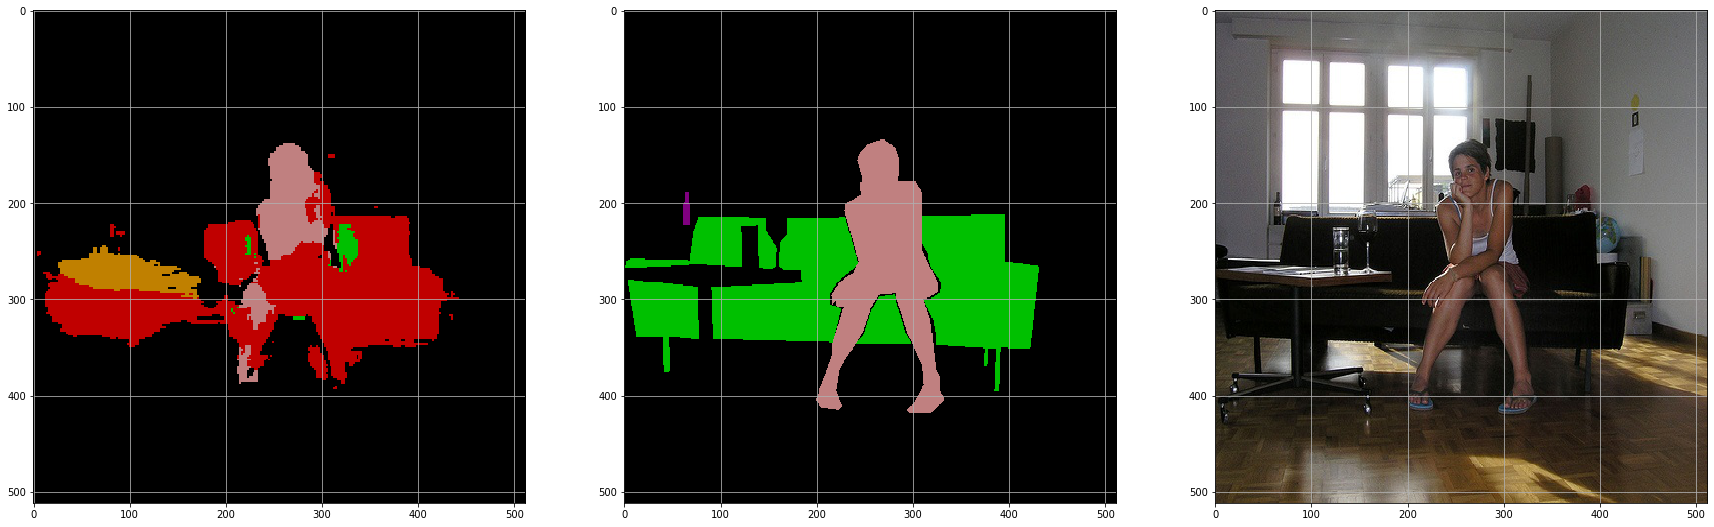

In [96]:
i=49
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(y_pred[i])
plt.grid()
plt.subplot(1,3,2)
plt.imshow(y_true[i])
plt.grid()
plt.subplot(1,3,3)
plt.imshow(valid_x[i,:,:,:])
plt.grid()

In [66]:
train_data_gen = DataGenerator(n_categories, image_size, 8, img_paths    , seg_img_paths, augmentation=True )

In [67]:
x,y = train_data_gen.__getitem__(0)

In [176]:
x = (x+1)/2
y =convert_y_to_image_array(y, image_size, n_categories, palette)

AttributeError: 'list' object has no attribute 'shape'

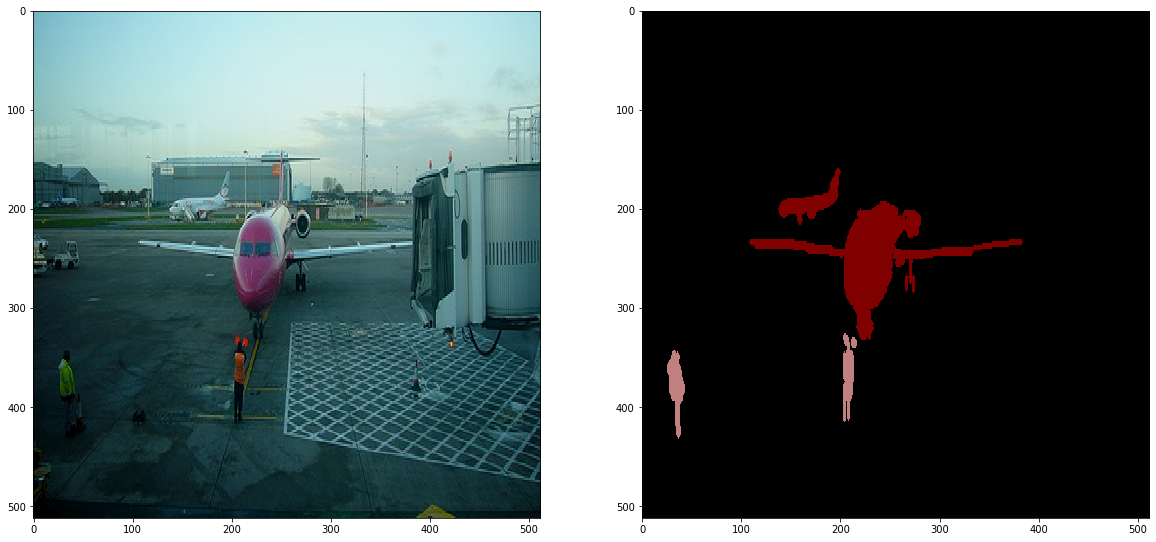

In [138]:
i=0
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(x[i,:,:,:])
plt.subplot(1,2,2)
plt.imshow(y[i])

In [36]:
from albumentations import *

In [39]:
x = make_x_from_image_paths(img_paths[0:10], image_size)
y = make_y_from_image_paths(seg_img_paths[0:10], image_size, n_categories)

In [137]:
i=
#aug=RandomCrop(p=1, height=300, width=300)
#aug=ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=1)
aug=Compose([HueSaturationValue(p=1)],p=1)
img=aug(image=x[i,:,:,:])["image"]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(x[i,:,:,:])
plt.subplot(1,2,2)
plt.imshow(img)

error: OpenCV(3.4.7) /opt/anaconda/conda-bld/opencv-suite_1571723438228/work/modules/imgproc/src/color.simd_helpers.hpp:90: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3>; VDepth = cv::impl::{anonymous}::Set<0, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [136]:
pred[0].max(axis=2).min()

0.47742096

In [124]:
pred[0].shape

(512, 512, 21)

In [201]:
def convert_y_to_image_array(y, image_size, n_categories, palette, threshold=0.0):
    out_img = []
    for i in range(y.shape[0]):
        out_img0 = np.zeros((*image_size, 3), np.float32)
        under_threshold = pred[i,:,:,:].max(2) < threshold
        y[i,under_threshold,0] = 1.0
        max_category = y[i,:,:,:].argmax(2)        
        for j in range(n_categories):
            out_img0[max_category==j] = palette[j,:]
        out_img.append(out_img0)
    return out_img

'20191128-10:34:02'